In [8]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [9]:
import numpy as np
import pandas as pd

In [10]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [12]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [13]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [14]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [15]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [16]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

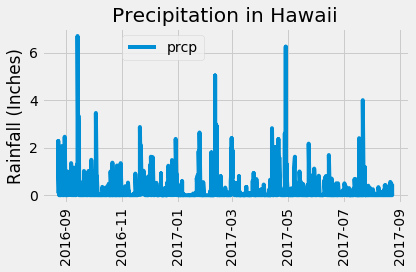

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
recent_date = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)

for date in recent_date:
    most_recent_date= date.date
    

most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")

# Calculate the date 1 year ago from the last data point in the database


one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

recent_prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(recent_prcp_data).dropna()

# Sort the dataframe by date

df['date'] = pd.to_datetime(df['date'])

# Use Pandas Plotting with Matplotlib to plot the data

plt.plot(df['date'], df['prcp'])
plt.title("Precipitation in Hawaii")

plt.ylabel('Rainfall (Inches)')
plt.legend(bbox_to_anchor=(0.2, 1.00))

# Rotate the xticks for the dates
plt.xticks(rotation='90')

plt.tight_layout()
plt.show()



![precipitation](Images/precipitation.png)

In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [32]:
# Design a query to show how many stations are available in this dataset?
stationsCount = session.query(Station).count()
print(f"Station Count: {stationsCount}")

Station Count: 9


In [33]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationCounts = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
stationCounts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
#set the most active station

stationID = stationCounts[0][0]

stationName = (session.query(Station.name)
                      .filter_by(station = stationID))
stationName = stationName[0][0]
print(f"The most active station is {stationID}: {stationName}.")

#query for highest temperature
highestTemp = (session.query(Measurement.tobs)
                      .filter(Measurement.station == stationID)
                      .order_by(Measurement.tobs.desc())
                      .first())
highestTemp = highestTemp[0]
print(f"The highest temperature recorded there is {highestTemp} degrees Farenheit.")

#query for lowest temperature
lowestTemp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == stationID)
                     .order_by(Measurement.tobs.asc())
                     .first())
lowestTemp = lowestTemp[0]
print(f"The lowest temperature recorded there is {lowestTemp} degrees Farenheit.")

#query for average temperature
avgTemp = (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == stationID))
avgTemp = '{0:.3}'.format(avgTemp[0][0])
print(f"The average temperature recorded there is {avgTemp} degrees Farenheit.")

The most active station is USC00519281: WAIHEE 837.5, HI US.
The highest temperature recorded there is 85.0 degrees Farenheit.
The lowest temperature recorded there is 54.0 degrees Farenheit.
The average temperature recorded there is 71.7 degrees Farenheit.


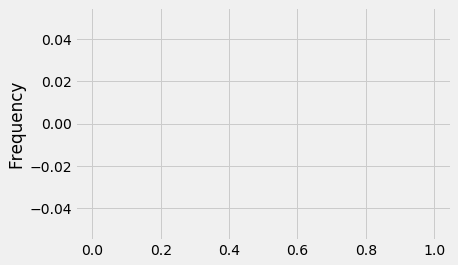

In [40]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stationName = session.query(Measurement.tobs).\
                                filter(Measurement.station==stationName).\
                                filter(Measurement.date >= one_year_ago).\
                                order_by(Measurement.date.desc()).all()

x = [x[0] for x in stationName]


plt.hist(x, bins=12)
plt.ylabel('Frequency')
plt.show()

![precipitation](Images/station-histogram.png)

In [41]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [42]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2017-01-01', '2017-01-10')
temps

[(60.0, 68.0327868852459, 77.0)]

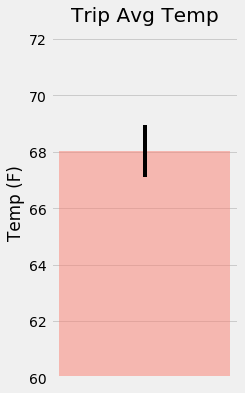

In [43]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
lower = temps[0][1] - temps[0][0]
upper = temps[0][2] - temps[0][1]

plt.figure(figsize=(3,6))
plt.bar(0, temps[0][1], yerr=[upper-lower], color='salmon', alpha=0.5)
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temp (F)')
plt.ylim(60)

plt.show()

In [52]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def precipitation(start_date, end_date):
    
        # Docstring for the function `calc_temps`
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-07-01','2017-07-14'))

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.1), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.08), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.06), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, None), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, None)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)



[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


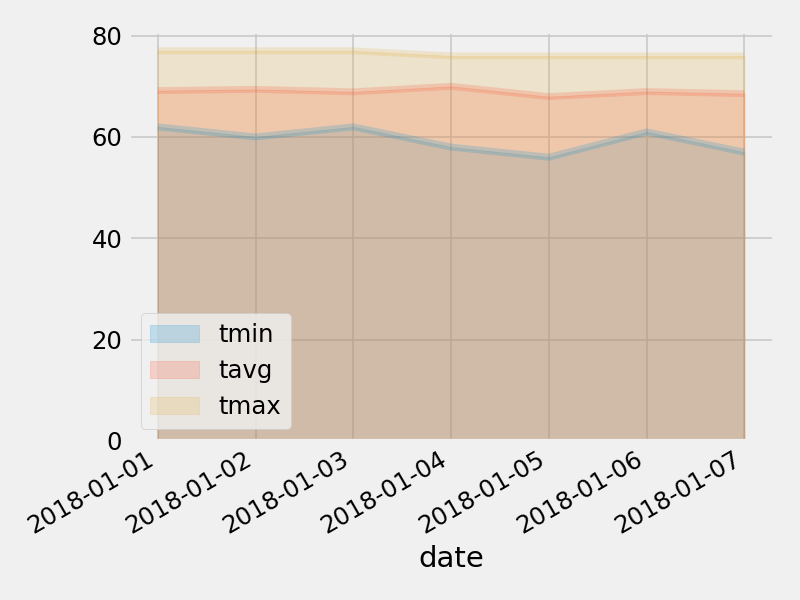

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
